# COMP5318 - Machine Learning and Data Mining: Assignment 2
<div style="text-align: right"> Group 86 </div>
<div style="text-align: right"> tlin4302 | 470322974 | Jenny Tsai-chen Lin </div>
<div style="text-align: right"> jsun4242 | 500409987 | Jiawei Sun </div>
<div style="text-align: right"> Code | ID | Name </div>

## The notebook includes sections :

    Section 1. Library and general functions 
    Section 2. Data descriptive summary and pre-processing
    Section 3. Implement algorithms
        3.1 AdaBoost Classifier
        3.2 Support-Vector-Machine Classifier
        3.3 Convolutional Neural Network Classifier
    Section 4. Compare result between algorithms in train dataset 
    Section 5: Best perfroming algorithms in testing data  (we will submit this in seperate notebook as well)
    Section 6. Hardware and software specifications

In response to 4 main parts of report requirement: 

    1. Try 3 different Machine Learning methods and compare their performance. | Section 3 & Section 4
    2. Choosing an appropriate model and its complexity | Section 3
    3. Using pre-processing techniques on the datasets | Section 2
    4. Computer infrastructure   | TBC
    5. Ease of prototyping
    6. Hardware and software specifications of the computer that you used for performance evaluation | Section 5

## Section 0. Switches

In [31]:
test_ABC = True
ABC_load_model = True

test_CNN_train = False
test_CNN_predict = True

test_SVC = True
SVC_load_model = True

## Section 1. Library and general functions 

In [21]:
#package loaded
#pip install PySimpleGUI
#pip install pyperclip
#pip install chess
#pip install python-chess

#  Go to anaconda prompt to install package imblearn
# anaconda: conda install -c glemaitre imbalanced-learn
#pip install kmeans-smote

from skimage import io, transform
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2

import time 

start_time = time.time()
#main()
print('--- {} seconds ---'.format(time.time() - start_time))

--- 0.0 seconds ---


### global variables

In [33]:
# choose one of below two line depend on you system ******

#g_dataset_dir = "./dataset/"   
g_dataset_dir = "../dataset/" 


#a_random_file = "./dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg"  
a_random_file = "../dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg" 

saved_model_path = "./saved_model/"
abc_model_file = saved_model_path + "abc_dump.pkl"
svc_model_file = saved_model_path + "svc_dump.pkl"


# define global variable 

g_train_dir = g_dataset_dir + "/train/"
g_test_dir = g_dataset_dir + "/test/"

g_image_size = 400

g_grid_row = 8
g_grid_col = 8

g_grid_num = g_grid_row * g_grid_col
g_grid_size = int(g_image_size / g_grid_row)


#Processing 1 - scale down 
g_down_sampled_size = 200
g_down_sampled_grid_size = int(g_grid_size / (g_image_size / g_down_sampled_size))

# global instance of mapping of char vs chess pieces
# reference: Forsyth–Edwards Notation, https://en.wikipedia.org/wiki/Forsyth%E2%80%93Edwards_Notation
# 
# pawn = "P", knight = "N", bishop = "B", rook = "R", queen = "Q" and king = "K"
# White pieces are designated using upper-case letters ("PNBRQK") while black pieces use lowercase ("pnbrqk")
# we use 0 to note an empty grid.
# 13 items in total.

g_piece_mapping = {
    "P" : "pawn",
    "N" : "knight",
    "B" : "bishop",
    "R" : "rook",
    "Q" : "queen",
    "K" : "king",

    "p" : "pawn",
    "n" : "knight",
    "b" : "bishop",
    "r" : "rook",
    "q" : "queen",
    "k" : "king",

    "0" : "empty_grid"
}

g_num_labels = len(g_piece_mapping)


### Helper codes for label & board

In [14]:
#DataHelper.py

import os

import cv2
from skimage import io
import numpy as np

import glob
import h5py

# get clean name by a path, where in our case this gets the FEN conviniently
def GetCleanNameByPath(file_name):
    return os.path.splitext(os.path.basename(file_name))[0]

# get full paths to the files in a directory.
def GetFileNamesInDir(path_name, extension="*", num_return = 0):
    if num_return == 0:
        return glob.glob(path_name + "/*." + extension)
    else:
        return glob.glob(path_name + "/*." + extension)[:num_return]

# get name list
def GetCleanNamesInDir(path_name, extension = "*", num_return = 0):
    names = GetFileNamesInDir(path_name, extension)
    offset = len(extension) + 1
    clean_names = [os.path.basename(x)[:-offset] for x in names]
    if num_return == 0:
        return clean_names
    else:
        return clean_names[:num_return]

# read dataset
def ReadImages(file_names, path = "", format = cv2.IMREAD_COLOR):
    if path == "":
        return [cv2.imread(f, format) for f in file_names]
    else:
        return [cv2.imread(path + "/" + f, format) for f in file_names]

# read image by name
def ReadImage(file_name, gray = False):
    return io.imread(file_name, as_gray = gray)


# h5py functions
    
# read h5py file
# we assume the labels and 
def ReadH5pyFile(file_name, data_name):
    h5_buffer = h5py.File(file_name)
    return h5_buffer[data_name].copy()

# write h5py file
def WriteH5pyFile(file_name, mat, data_name = "dataset"):
    with h5py.File(file_name, 'w') as f:
        f.create_dataset(data_name, data = mat)


In [15]:
#BoardHelper.py

import re
import string
from collections import OrderedDict 

import numpy as np
import skimage.util
from skimage.util.shape import view_as_blocks

from ChessGlobalDefs import *

#FEN TO LABELS OF SQUARES
def FENtoL(fen): 
    rules = {
        r"-": r"",
        r"1": r"0",
        r"2": r"00",
        r"3": r"000",
        r"4": r"0000",
        r"5": r"00000",
        r"6": r"000000",
        r"7": r"0000000",
        r"8": r"00000000",
    }

    for key in rules.keys():
        fen = re.sub(key, rules[key], fen)

    return list(fen)


# Label array to char list:
def LabelArrayToL(arr):
    rules = {
        0 : "P",
        1 : "N",
        2 : "B",
        3 : "R",
        4 : "Q",
        5 : "K",

        6 : "p",
        7 : "n",
        8 : "b",
        9 : "r",
       10 : "q",
       11 : "k",

       12 : "0"
    }

    flattened = arr.flatten(order = "C")

    L = []

    for x in flattened:
        L.append(rules[x])

    return L

# char list to FEN
def LtoFEN(L):

    FEN = ""
    
    for y in range(8):
        counter = 0
        for x in range(8):
            idx = x + y * 8
            char = L[idx]

            if char == "0":
                counter += 1
                if x == 7:
                    FEN += str(counter)
            else:
                if counter:
                    FEN += str(counter)
                    counter = 0

                FEN += char
        if y != 7:
            FEN += "-"
        
            
    return FEN



# FEN to one-hot encoding, in our case, it returns an 64 by 13 array, with each row as a one-hot to a grid.
def FENtoOneHot(fen):

    # this rule is in the same format as g_piece_mapping
    #rules = {
    #    "P" : np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "N" : np.array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "B" : np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "R" : np.array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "Q" : np.array([0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
    #    "K" : np.array([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
    #                    
    #    "p" : np.array([0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]),
    #    "n" : np.array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0]),
    #    "b" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]),
    #    "r" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]),
    #    "q" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0]),
    #    "k" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]),
    #                    
    #    "0" : np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1])
    #}
    rules = {
        "P" : 0,
        "N" : 1,
        "B" : 2,
        "R" : 3,
        "Q" : 4,
        "K" : 5,

        "p" : 6,
        "n" : 7,
        "b" : 8,
        "r" : 9,
        "q" : 10,
        "k" : 11,

        "0" : 12
    }

    L = FENtoL(fen)
    one_hot_array = np.zeros((g_grid_num, g_num_labels), dtype = np.int32) # 64 by 13
    for i, c in enumerate(L):
        one_hot_array[i, rules[c]] = 1

    return one_hot_array

# get 8*8 char matrix
def LtoCharMat(l):
    if type(l) == list:
        return np.array(l).reshape((8,8))
    if type(l) == str:
        return np.array([l]).reshape((8,8))

def GetBoardCell(board_image, row = 0, col = 0, size = 50):
    return np.array(board_image)[row*size:(row+1)*size,col*size:(col+1)*size]

# get grids of image
def ImageToGrids(image, grid_size_x, grid_size_y):
    return skimage.util.shape.view_as_blocks(image, block_shape = (grid_size_y, grid_size_x, 3)).squeeze(axis = 2)


#### Confusion matrix - heatmap

In [16]:
from sklearn.metrics import confusion_matrix


import pandas as pd

# function - to create confusion matrix
def conf_mat(true,pred):
    A = pd.Series(true, name='Actual')
    P = pd.Series(pred, name='Predict')
    #conf_matt  = pd.crosstab(A, P, margins=True)
    conf_matt  = pd.crosstab(A, P)
    return conf_matt


#function - to create heatmap for confusion matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(conf_matt, cmap=plt.cm.gray_r): 
    conf_norm = conf_matt / conf_matt.sum(axis=1)  
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(conf_norm, cmap=cmap)
    fig.colorbar(cax)
    tick_marks = np.arange(len(conf_norm.columns))
    plt.xticks(tick_marks, conf_norm.columns)
    plt.yticks(tick_marks, conf_norm.index)
    plt.ylabel(conf_norm.index.name)
    plt.xlabel(conf_norm.columns.name)

## Section 2. Data descriptive summary and pre-processing

### Pre-processing - generic

In [17]:
# split into 64 small square from 1 board
# image resized to 400x 400 to 200x 200. 64 square at 25x 25 each

def PreprocessImage(image):
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
    # 1st and 2nd dim is 8
    grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

    # debug
    #plt.imshow(grids[0][5])
    #plt.show()

    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)


# split into 64 small square from 1 board
def func_generator(train_file_names):
    for image_file_name in train_file_names:
        img = ReadImage(image_file_name)
        x = PreprocessImage(img)
        y = np.array(FENtoOneHot(GetCleanNameByPath(image_file_name)))
    return x, y

### Pre-processing  - w SIFT to dataframe

In [18]:
#depend on you cv2 package. select one of below two lines  ******
# g_sift_extractor = sift = cv2.SIFT_create(edgeThreshold = 0)
g_sift_extractor = sift = cv2.SIFT_create(edgeThreshold = 0)


# Processing image with sift
import cv2

def ExtractSIFTForGrid(board_image, row, col, center_x = 25, center_y = 25, radius = 45):
    kps = [cv2.KeyPoint(x = center_x + 50 * col, y = center_y + 50 * row, _size = 45)]
    keypoints, descriptors = g_sift_extractor.compute(image = board_image, keypoints = kps)
    return keypoints[0], descriptors[0, :]


def PreprocessImage_sift(image):
    image = cv2.Canny(image,100,200)
    image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
    # 1st and 2nd dim is 8
    image = image[..., np.newaxis]
    grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size, channels = 1)
    return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size)

# atomic func:
def func_sift(file_name):
    img = ReadImage(image_file_name)
    x = PreprocessImage_sift(img)
    y = np.array(FENtoL(GetCleanNameByPath(image_file_name)))
    return x, y
    
    
# split into 64 small square from 1 
def func_generator_sift(train_file_names):
    xs = []
    ys = []
    for image_file_name in train_file_names:
        x, y = func_sift(image_file_name)
        xs.append(x)
        ys.append(y)
        
    return xs, ys


### Example of SIFT

file name: ../dataset/train/1b1B1b2-2pK2q1-4p1rB-7k-8-8-3B4-3rb3.jpeg


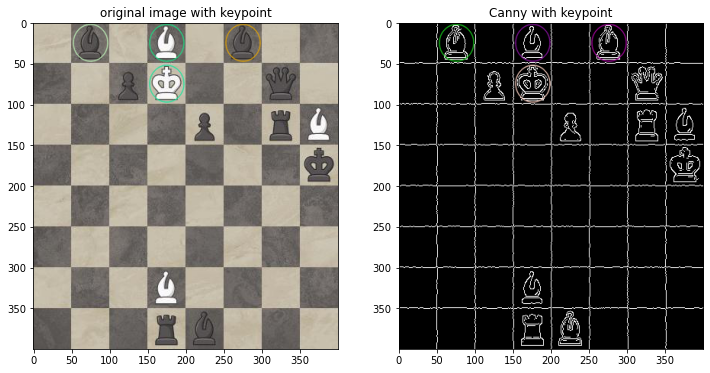

SIFT OUTPUT for Canny at squares


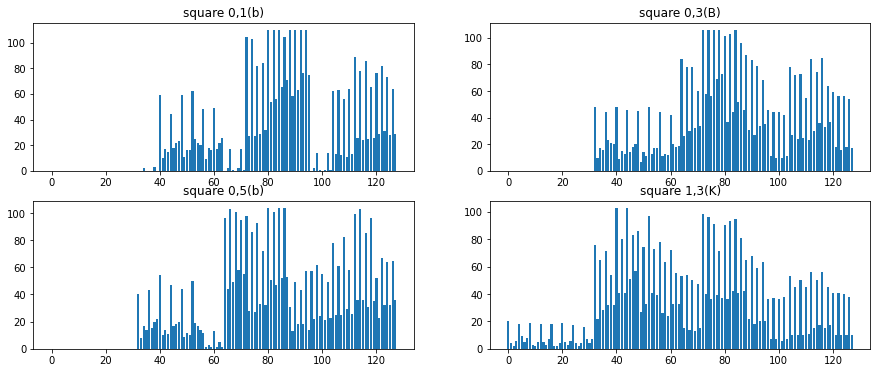

In [19]:
# Illustration of 
import cv2
#print("Sift: decriptor size:", cv2.SIFT_create().descriptorSize())
img = ReadImage(a_random_file)

img1 = cv2.Canny(img,100,200)

kp, desc = ExtractSIFTForGrid(img1, 0, 1)
kp2, desc2 = ExtractSIFTForGrid(img1, 0, 3)
kp3, desc3 = ExtractSIFTForGrid(img1, 0, 5)
kp4, desc4 = ExtractSIFTForGrid(img1, 1, 3)
img_kp = cv2.drawKeypoints(img, [kp, kp2,kp3,kp4], img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp1 = cv2.drawKeypoints(img1, [kp, kp2,kp3,kp4], img1, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

print('file name:',a_random_file)


f = plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.imshow(img_kp, aspect='auto')
plt.title('original image with keypoint')

plt.subplot(1, 2, 2)
plt.imshow(img_kp1, aspect='auto')
plt.title('Canny with keypoint')
plt.show()

print('SIFT OUTPUT for Canny at squares')
plt.figure(figsize=(15,6))
#plt.tight_layout()
plt.subplot(2, 2, 1)
plt.title('square 0,1(b)')
plt.bar(x = range(128), height = desc)
plt.xticks(x = range(128))

plt.subplot(2,2, 2)
plt.title('square 0,3(B)')
plt.bar(x = range(128), height = desc2)
plt.xticks(x = range(128))

plt.subplot(2,2,3)
plt.title('square 0,5(b)')
plt.bar(x = range(128), height = desc3)
plt.xticks(x = range(128))


plt.subplot(2,2,4)
plt.title('square 1,3(K)')
plt.bar(x = range(128), height = desc4)
plt.xticks(x = range(128))
plt.show()



###  Read image -  original functon

start_time = time.time()
num_train = 10
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)


X,Y = func_generator_sift(train_file_names)

print('--- {} seconds ---'.format(time.time() - start_time))

###  Read Image - parallel version

In [20]:
from joblib import Parallel, delayed

def Preprocess_parallel(file_names, job_count = 6):
    result = Parallel(n_jobs=job_count)(delayed(func_sift)(file_name) for file_name in file_names)
    return zip(*result)

start_time = time.time()
num_train = 10
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)
df_sift= func_generator_sift(train_file_names)

xs, ys = Preprocess_parallel(train_file_names)
print('--- {} seconds ---'.format(time.time() - start_time))

### Read file names

In [12]:
# Using FEN to identify grid with chess

num_train = 80000
num_test= 20000

# Reading train labels 80k
train_file_names = GetFileNamesInDir(g_train_dir, extension = "jpeg",num_return = num_train)


# Reading test label 20k
test_file_names = GetFileNamesInDir(g_test_dir, extension = "jpeg",num_return = num_test)


# Reading subset labels(image with more than 10 chess as high quality data)
ys = []
for image_file_name in train_file_names:
    ys.extend(FENtoL(GetCleanNameByPath(image_file_name)))

df =pd.DataFrame(np.array(ys).reshape(num_train,64))
df['w'] = (df != '0').astype(int).sum(axis=1)
df['FEN']=train_file_names
df_selected = df[df['w']>=10]
df_selected = df_selected['FEN'].values.tolist()
train_file_names_highqualty = df_selected
num_subset=len(train_file_names_highqualty)


### import data

In [13]:
# import data - train 80K
start_time = time.time()
xs_train, ys_train = Preprocess_parallel(train_file_names)

# reshape train
start_time = time.time()
xs_train= np.array(xs_train).reshape(num_train*64,25*25)
ys_train = np.array(ys_train).reshape(64*len(np.array(ys_train)))
print('xs_train, ys_train generated:', len(xs_train))
print('--- {} seconds ---'.format(time.time() - start_time))

xs_train, ys_train generated: 5120000
--- 43.40502715110779 seconds ---


In [ ]:
start_time = time.time()
# import data - test 20K
xs_test, ys_test = Preprocess_parallel(test_file_names)
print('xs_test, ys_test generated:',len(xs_test))


# reshape test
start_time = time.time()
xs_test= np.array(xs_test).reshape(num_test*64,25*25)
ys_test = np.array(ys_test).reshape(64*len(np.array(ys_test)))
print('--- {} seconds ---'.format(time.time() - start_time))


In [ ]:
start_time = time.time()
# import data - subset
xs, ys = Preprocess_parallel(train_file_names_highqualty)
print("Subset train data (>10 chesses) to", len(train_file_names_highqualty),"from total",len(train_file_names))
print('xs, ys generated:',len(xs))


# reshape subset
start_time = time.time()
xs= np.array(xs).reshape(num_subset*64,25*25)
ys= np.array(ys).reshape(64*len(np.array(ys)))
print('--- {} seconds ---'.format(time.time() - start_time))


### Split train and validation dataset

In [ ]:
start_time = time.time()

from sklearn.model_selection import train_test_split
X_train, X_val, Y_train, Y_val = train_test_split(
    xs, ys, test_size=0.33, random_state=0)
print(X_train.shape, X_val.shape, Y_train.shape, Y_val.shape)
print('--- {} seconds ---'.format(time.time() - start_time))

### Balancing classes (undersampling)

In [ ]:


# ref from https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
#https://imbalanced-learn.readthedocs.io/en/stable/auto_examples/under-sampling/plot_comparison_under_sampling.html#sphx-glr-auto-examples-under-sampling-plot-comparison-under-sampling-py

import numpy as np
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler
# if experience ImportError: cannot import name '_UnstableArchMixin' from 'sklearn.base' refer below for trouble shoot.
#https://stackoverflow.com/questions/55447538/importerror-cannot-import-name-unstablearchmixin-from-sklearn-base/55448307


rus = RandomUnderSampler(sampling_strategy='majority', random_state=42)
X_resampled, Y_resampled = rus.fit_resample(X_train, Y_train)

[print('Class {} has {} instances'.format(label, count))
for label, count in zip(*np.unique(Y_train, return_counts=True))]

print()
[print('Class {} has {} instances after undersampling'.format(label, count))
 for label, count in zip(*np.unique(Y_resampled, return_counts=True))]

## Section 3. Implement algorithms

### Section 3.1 AdaBoostClassifier (ABC)

#### base classifier- small sample

In [ ]:
# base classifier - Tree classifier
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
#Apply pre-pruning by limiting the depth of the tree - max_depth=2
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree.fit(X_train[:1000], Y_train[:1000])
#Evaluate its performance on the training and test set
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, Y_val)))

print('--- {} seconds ---'.format(time.time() - start_time))

In [ ]:
# base classifier - Tree classifier (w/ balanced data)
from sklearn.tree import DecisionTreeClassifier

start_time = time.time()
#Apply pre-pruning by limiting the depth of the tree - max_depth=2
tree = DecisionTreeClassifier(criterion='entropy', max_depth=2, random_state=42)
tree.fit(X_resampled[:1000], Y_resampled[:1000])
#Evaluate its performance on the training and test set
print("Accuracy on training set: {:.3f}".format(tree.score(X_train, Y_train)))
print("Accuracy on validation set: {:.3f}".format(tree.score(X_val, Y_val)))

print('--- {} seconds ---'.format(time.time() - start_time))

#### AdaBoostClassifier - small sample

In [ ]:
# ABC classifier

from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
start_time = time.time()

ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.5, random_state=42)
ada.fit(X_train[:1000], Y_train[:1000])
y_pred_ada = ada.predict(X_val)


#Evaluate its performance on the training and test set
print("AdaBoost- accuracy on validation set:", accuracy_score(Y_val, y_pred_ada))

print('--- {} seconds ---'.format(time.time() - start_time))

In [ ]:
y_pred_ada

####  Hpyer parameter tunning

In [ ]:
###https://machinelearningmastery.com/adaboost-ensemble-in-python/

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import GridSearchCV

param_grid = [{'n_estimators': np.arange(10,50,5),
              'learning_rate': [0.01, 0.05, 0.1, 1]
             }]

start_time = time.time()
abc = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid)
abc.fit(X_train[:1000], Y_train[:1000])  # temp use 1000 sample- block run forever

print('--- {} seconds ---'.format(time.time() - start_time))

#### GridSearchCV Result

In [ ]:
# Print grid search results
from sklearn.metrics import classification_report

means = abc.cv_results_['mean_test_score']
stds = abc.cv_results_['std_test_score']
params = abc.cv_results_['params']

print('Grid search mean and stdev:\n')

for mean, std, p in zip(means, stds, params):
    print("%0.3f (+/-%0.03f) for %r"% (mean, std * 2, p))

# Print best params
print('\nBest parameters:', abc.best_params_)
print("Detailed classification report:")
print()
print(classification_report(Y_val, abc.predict(X_val)))
print()

### 10 fold - Training datat

Cv reference
https://scikit-learn.org/stable/modules/cross_validation.html

options for 10 fold
    1. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html
    2. https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedKFold.html (Preferred)
    " StratifiedKFold is a variation of k-fold which returns stratified folds: each set contains approximately the same percentage of samples of each target class as the complete set." 
    

In [ ]:
#ref https://www.kaggle.com/sudhirnl7/logistic-regression-with-stratifiedkfold

from sklearn.model_selection import StratifiedKFold


i = 1
scores=[]
y_pred=[]
y_true =[]
kf = StratifiedKFold(n_splits=10,shuffle=False)
for train_index, test_index in skf.split(xs_train, ys_train):
    print('{} of KFold {}'.format(i,kf.n_splits))
  
    X_train, X_test = xs_train[train_index], xs_train[test_index]
    Y_train, Y_test = ys_train[train_index], ys_train[test_index]
    
    #Best parameters: {'learning_rate': 0.01, 'n_estimators': 30} from GridSearchCV
    ada_clf = AdaBoostClassifier(n_estimators=30, learning_rate=0.01, random_state=42)
    ada_clf.fit(X_train[:1000], Y_train[:1000])
    
    pred = ada_clf.predict(X_test)
    score = accuracy_score(Y_test, pred)
    print('Accuracy score:',score)
    i = i+1



### Prediction at Testing

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

start_time = time.time()

#Best parameters: {'learning_rate': 0.01, 'n_estimators': 30} from GridSearchCV
y_pred_test = ada_clf.predict(xs_test)
print("AdaBoost ensemble - accuracy on test set:")
print(accuracy_score(ys_test, y_pred_test))

print('--- {} seconds ---'.format(time.time() - start_time))

### reflection 
    there in need to use large number of training data for model

### Section 3.2 SVM Classifier (SVC)

#### Base class for all classifiers

In [23]:
import abc

# interface of the classifiers
class IClassifier:

    # this method should accept a list of file names of the training data
    @abc.abstractmethod
    def Train(self, train_file_names):
        raise NotImplementedError()

    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    @abc.abstractmethod
    def Predict(self, query_data):
        raise NotImplementedError()

#### Class definition for SVC

In [25]:
from sklearn import svm
import numpy as np

# image io and plotting
from skimage import io, transform
import skimage.util
from skimage.util.shape import view_as_blocks
from matplotlib import pyplot as plt

# parallel processing
from joblib import Parallel, delayed
# model save and load
import pickle
import os
# profiling
import time

# joblib needs the kernel to be a top-level function, so we defined it here.
def PreprocessKernel(name):
    img = DataHelper.ReadImage(name, gray = True)
    grids = SVCClassifier.SVCPreprocess(img)
    labels = np.array(FENtoOneHot(GetCleanNameByPath(name))).argmax(axis=1)
    return grids, labels

# SVM Classifier
class SVCClassifier(IClassifier):

    def __init__(self):
        self.__svc__ = svm.SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                          decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
                          max_iter=-1, probability=False, random_state=None, shrinking=True,
                          tol=0.001, verbose=False)

    # this method should accept a list of file names of the training data
    def Train(self, train_file_names):
        print("svc: reading image.")
        start_time = time.time()
        xs, ys = SVCClassifier.PreprocessParallelWrapperFunc(train_file_names)
        print("svc: finished reading image, {} sec.".format(time.time() - start_time))
        # train
        print("svc: start training.")
        start_time = time.time()
        self.__svc__.fit(xs, ys)
        print("svc: finished. {} sec.".format(time.time() - start_time))

    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = SVCClassifier.SVCPreprocess(query_data)
        y_pred = self.__svc__.predict(grids)
        
        return LabelArrayToL(y_pred)


    # parallel pre-process wrapper:
    @staticmethod
    def PreprocessParallelWrapperFunc(file_names, num_thread = 1):
        result = Parallel(n_jobs = num_thread)(delayed(PreprocessKernel)(file_name) for file_name in file_names)
        xs, ys = zip(*result)
        xs = np.concatenate(xs, axis=0)
        ys = np.concatenate(ys)
        return xs, ys

    @staticmethod
    def SVCPreprocess(img):
        img = transform.resize(img, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        grids = skimage.util.shape.view_as_blocks(img, block_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size))
        grids = grids.reshape((-1, grids.shape[3], grids.shape[3]))
        grids = grids.reshape((grids.shape[0], grids.shape[1] * grids.shape[1]))
        return grids

    def SaveModel(self, save_file_name):
        os.makedirs(os.path.dirname(save_file_name), exist_ok = True)
        with open(save_file_name, 'wb') as file:
            pickle.dump(self.__svc__, file)

    def LoadModel(self, load_file_name):
        with open(load_file_name, 'rb') as file:
            self.__svc__ = pickle.load(file)

#### Test code for SVC

In [36]:
if test_SVC:
    svc = SVCClassifier()
    train_names = GetFileNamesInDir(g_train_dir)

    if SVC_load_model:
        print("svc: loading model from " + svc_model_file)
        svc.LoadModel(svc_model_file)
    else:
        svc.Train(train_names[:500])

    y_truth = FENtoL(GetCleanNameByPath(a_random_file))
    img = ReadImage(a_random_file, gray = True)
    pred = svc.Predict(img)
    print("truth:  ", ''.join(y_truth))
    print("pred :  ", ''.join(pred))

    # save model
    if not SVC_load_model:
        print("svc: saving model to " + svc_model_file)
        svc.SaveModel(svc_model_file)

svc: loading model from ./saved_model/svc_dump.pkl
truth:   0b0B0b0000pK00q00000p0rB0000000k0000000000000000000B0000000rb000
pred :   000B0000000K00000000p0rB0000000k0000000000000000000B0000000r0000


### Section 3.2 Convolutional Neural Network Classifier (CNN)

#### Class definition for CNN

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import cv2
from skimage import io, transform
import numpy as np
import os

#import tensorflow as tf
#from tensorflow import keras
#from tf.keras.models import Sequential
#from tf.keras.layers.core import Flatten, Dense, Dropout, Activation
#from tf.keras.layers.convolutional import Convolution2D

class CNNClassifier(IClassifier):

    # the file name format does not accept batch as parameter. link:
    # https://github.com/tensorflow/tensorflow/issues/38668
    s_check_point_file_name = "./CNN_training_checkpoint/cp_{epoch:02d}-{accuracy:.2f}.ckpt"
    s_check_point_path = os.path.dirname(s_check_point_file_name)
    s_save_frequence = 10000 # save a checkpoint every s_save_frequence batches

    def __init__(self):
        
        #tf.config.threading.set_inter_op_parallelism_threads(3)
        #tf.config.threading.set_intra_op_parallelism_threads(3)

        # define our model
        self.__model__ = keras.Sequential(
            [
                layers.Convolution2D(32, (3, 3), input_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size, 3)),
                layers.Activation('relu'),
                layers.Dropout(0.1),
                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Convolution2D(32, (3, 3)),
                layers.Activation('relu'),

                layers.Flatten(),
                
                layers.Dense(128),
                layers.Activation('relu'),
                layers.Dropout(0.3),

                layers.Dense(13),
                layers.Activation("softmax")
            ]
        )

        self.__model__.compile(loss = "categorical_crossentropy", optimizer = 'adam', metrics = ["accuracy"])
        self.__model__.summary()

        self.__save_check_point_callback__ = tf.keras.callbacks.ModelCheckpoint(
            filepath = CNNClassifier.s_check_point_file_name,
            monitor='val_accuracy',
            save_weights_only = True,
            save_freq = CNNClassifier.s_save_frequence,
            verbose = 1
            )


     # generator
    @staticmethod
    def func_generator(train_file_names):
        for image_file_name in train_file_names:
            img = ReadImage(image_file_name)
            x = CNNClassifier.PreprocessImage(img)
            y = np.array(FENtoOneHot(GetCleanNameByPath(image_file_name)))
            yield x, y

    # this method should accept N * 64 * m * n numpy array as train data, and N lists of 64 chars as label.
    def Train(self, train_data_names):
        train_size = len(train_data_names)

        # try load last checkpoint
        if not self.LoadMostRecentModel():
            os.makedirs(CNNClassifier.s_check_point_path, exist_ok = True)

        # train
        self.__model__.fit(CNNClassifier.func_generator(train_data_names),
                           use_multiprocessing = False,
                           #batch_size = 1000,
                           steps_per_epoch = train_size / 10,
                           epochs = 5,
                           callbacks = [self.__save_check_point_callback__],
                           verbose = 1)


    # this should accept a 64 * m * n numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = CNNClassifier.PreprocessImage(query_data)
        y_pred = self.__model__.predict(grids).argmax(axis=1)

        return LabelArrayToL(y_pred)

    def SaveModel(self):
        os.makedirs(CNNClassifier.s_check_point_path, exist_ok = True)
        __model__.save_weights(CNNClassifier.s_check_point_file_name)

    def LoadMostRecentModel(self):
        return self.LoadMostRecentModelFromDirectory(CNNClassifier.s_check_point_path)
    
    def LoadMostRecentModelFromDirectory(self, path):
        try:
            last_cp = tf.train.latest_checkpoint(path)
            self.__model__.load_weights(last_cp)
            print("Loaded checkpoint from " + last_cp)
            return True
        except:
            print("No checkpoint is loaded.")
            return False

    def TestAccuracy(self, test_file_names):
        num_files = len(test_file_names)

        predict_result = self.__model__.predict(CNNClassifier.func_generator(test_file_names)).argmax(axis=1)
        predict_result = predict_result.reshape(num_files, -1)
        predicted_fen_arr = np.array([LtoFEN(LabelArrayToL(labels)) for labels in predict_result])
        test_fens = np.array([GetCleanNameByPath(file_name) for file_name in test_file_names])

        final_accuracy = (predicted_fen_arr == test_fens).astype(np.float).mean()
        return final_accuracy

    @staticmethod
    def PreprocessImage(image):
        image = transform.resize(image, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        
        # 1st and 2nd dim is 8
        grids = ImageToGrids(image, g_down_sampled_grid_size, g_down_sampled_grid_size)

        # debug
        #plt.imshow(grids[0][3])
        #plt.show()

        return grids.reshape(g_grid_row * g_grid_col, g_down_sampled_grid_size, g_down_sampled_grid_size, 3)

#### test code for CNN

In [44]:
if test_CNN_train:
    cnn = CNNClassifier()
    train_names = GetFileNamesInDir(g_train_dir)
    cnn.Train(train_names)


if test_CNN_predict:
    cnn = CNNClassifier()
    cnn.LoadMostRecentModel()
    predicted_label = cnn.Predict(ReadImage(a_random_file))
    L = predicted_label
    FEN = LtoFEN(L)
    print("predicted: " + FEN)
    print("Original:  " + GetCleanNameByPath(a_random_file))

    test_file_names = GetFileNamesInDir(g_test_dir)[:1000]
    print("CNN: Testing accuracy for {} board images.".format(len(test_file_names)))
    accuracy = cnn.TestAccuracy(test_file_names)
    print("CNN: Final accuracy: {}".format(accuracy))

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 23, 23, 32)        896       
_________________________________________________________________
activation_20 (Activation)   (None, 23, 23, 32)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 23, 23, 32)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 21, 21, 32)        9248      
_________________________________________________________________
activation_21 (Activation)   (None, 21, 21, 32)        0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 19, 19, 32)        9248      
_________________________________________________________________
activation_22 (Activation)   (None, 19, 19, 32)       

In [45]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import numpy as np

# image io and plotting
from skimage import io, transform
import skimage.util
from skimage.util.shape import view_as_blocks
from matplotlib import pyplot as plt
# parallel processing
from joblib import Parallel, delayed
# model save and load
import pickle
import os
# profiling
import time

# joblib needs the kernel to be a top-level function, so we defined it here.
def PreprocessKernel(name):
    img = DataHelper.ReadImage(name, gray = True)
    grids = ABClassifier.ABCPreprocess(img)
    labels = np.array(FENtoOneHot(GetCleanNameByPath(name))).argmax(axis=1)
    return grids, labels

# Adaboost Classifier
class ABClassifier(IClassifier):

    def __init__(self):
        self.__abc__ = AdaBoostClassifier(n_estimators=30, base_estimator = \
                                          DecisionTreeClassifier(criterion='gini', max_depth=5), learning_rate=0.5)

    # this method should accept a list of file names of the training data
    def Train(self, train_file_names):
        print("abc: reading image.")
        start_time = time.time()
        xs, ys = ABClassifier.PreprocessParallelWrapperFunc(train_file_names)
        print("abc: finished reading image, {} sec.".format(time.time() - start_time))
        # train
        print("abc: start training.")
        start_time = time.time()
        self.__abc__.fit(xs, ys)
        print("abc: finished. {} sec.".format(time.time() - start_time))


    # this should accept a 400 * 400 * 3 numpy array as query data, and returns the fen notation of the board.
    def Predict(self, query_data):
        grids = ABClassifier.ABCPreprocess(query_data)
        y_pred = self.__abc__.predict(grids)
        
        return LabelArrayToL(y_pred)


    # parallel pre-process wrapper:
    @staticmethod
    def PreprocessParallelWrapperFunc(file_names, num_thread = 1):
        result = Parallel(n_jobs = num_thread)(delayed(PreprocessKernel)(file_name) for file_name in file_names)
        xs, ys = zip(*result)
        xs = np.concatenate(xs, axis=0)
        ys = np.concatenate(ys)
        return xs, ys


    @staticmethod
    def ABCPreprocess(img):
        img = transform.resize(img, (g_down_sampled_size, g_down_sampled_size), mode='constant')
        grids = skimage.util.shape.view_as_blocks(img, block_shape = (g_down_sampled_grid_size, g_down_sampled_grid_size))
        grids = grids.reshape((-1, grids.shape[3], grids.shape[3]))
        grids = grids.reshape((grids.shape[0], grids.shape[1] * grids.shape[1]))
        return grids

    def SaveModel(self, save_file_name):
        os.makedirs(os.path.dirname(save_file_name), exist_ok = True)
        with open(save_file_name, 'wb') as file:
            pickle.dump(self.__abc__, file)

    def LoadModel(self, load_file_name):
        with open(load_file_name, 'rb') as file:
            self.__abc__ = pickle.load(file)

#### Test code for ABC

In [48]:
if test_ABC:
    abc = ABClassifier()
    train_names = GetFileNamesInDir(g_train_dir)

    if ABC_load_model:
        print("abc: loading model from " + abc_model_file)
        abc.LoadModel(abc_model_file)
    else:
        abc.Train(train_names)

    y_truth = FENtoL(GetCleanNameByPath(a_random_file))
    img = ReadImage(a_random_file, gray = True)
    pred = abc.Predict(img)
    print("truth:  ", ''.join(y_truth))
    print("pred :  ", ''.join(pred))

    # save model
    if not ABC_load_model:
        print("abc: saving model to " + abc_model_file)
        abc.SaveModel(abc_model_file)

abc: loading model from ./saved_model/abc_dump.pkl
truth:   0b0B0b0000pK00q00000p0rB0000000k0000000000000000000B0000000rb000
pred :   0b0B0b0000pK00q00000p0rB0000000k0000000000000000000B0000000rb000


### Bonus: GUI: see GUI_with_Classifiers.ipynb